# Source Panel Method

In [42]:
%run resources/resources.ipynb

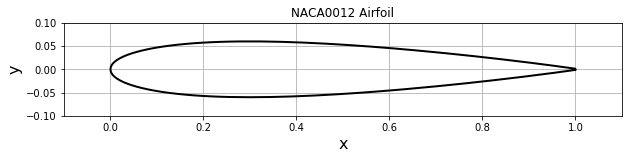

In [43]:
# read the geometry from a data file
naca_filepath = os.path.join('resources', 'naca0012.dat')
with open(naca_filepath, 'r') as filename:
    x, y = np.loadtxt(filename, dtype=float, delimiter='\t', unpack=True)
    
# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.title('NACA0012 Airfoil')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [44]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    
    R = (x.max()-x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*np.cos(np.linspace(0, 2*np.pi, N+1))
    
    x_ends = np.copy(x_circle)
    y_ends = np.empty_like(x_ends)
    
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinates of end points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
        
    panels = np.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
            
    return panels

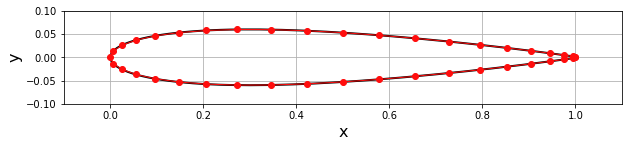

In [47]:
# let's do this
N=40
panels = define_panels(x, y)

# plot geometry and panels
width = 10
plt.figure(figsize=(width, width))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
         np.append([panel.ya for panel in panels], panels[0].ya),
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#FF0D0D')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

## Free stream conditions

In [48]:
# free stream instance
u_inf = 1.0
alpha = 0.0
fs = Freestream(u_inf, alpha)

## Flow tangency boundary condition